In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests

# Alquiler

En el caso de Madrid tenía casos para toda la CC.AA., pero en realidad sólo necesito para el municipio de Madrid. Por tanto importo la geometría del municipio y filtro sólo las observaciones que están en él. 

In [2]:
amb=pd.read_excel('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/primera_ronda/a-amb-marzo24.xlsx')
mad=pd.read_excel('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/primera_ronda/a-prov_mad-marzo24.xlsx')

# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(mad['Lon_X'], mad['Lat_Y'])]
crs = 'epsg:4326'  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(mad, crs=crs, geometry=geometry)
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

geomad=gpd.read_file('G:/Mi unidad/Datos/españa/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')
geomad=geomad[geomad['NAMEUNIT']=='Madrid']

munmad = gpd.sjoin(gdf_puntos, geomad[['geometry']], how='inner', predicate='intersects')
munmad=munmad.drop(['geometry','index_right'],axis=1)

In [3]:
print(len(mad))
print(len(munmad))

2405
1983


Creo una columna que me indique los quintiles a los que pertenece cada observación.

In [4]:
# Creas una nueva columna en cada DataFrame con los quintiles
amb['qprecio'] = pd.qcut(amb['precio_euros'], 5, labels=False)
munmad['qprecio'] = pd.qcut(munmad['precio_euros'], 5, labels=False)

In [5]:
len(amb)

2417

In [6]:
print(amb['qprecio'].unique())
print(munmad['qprecio'].unique())

[0 1 2 3 4]
[0 1 4 2 3]


In [7]:
print(len(amb[amb['qprecio']==0]))
print(len(amb[amb['qprecio']==1]))
print(len(amb[amb['qprecio']==2]))
print(len(amb[amb['qprecio']==3]))
print(len(amb[amb['qprecio']==4]))

517
467
468
489
476


Calculo la muestra aleatoria.

En teoría debería elegir un valor cercano al 10%, pero como queremos tener sólo 140 observaciones para la primera revisión, procedo a usar sólo el 0.3%.

In [8]:
# Calcula el tamaño de muestra deseado para cada quintil
tamano_muestra_por_quintil = int(len(amb) * 0.0015)  

# Define una función para muestrear estratificadamente cada DataFrame
def muestreo_estratificado(df):
    # Realiza el muestreo estratificado por quintil
    muestra_estratificada = df.groupby('qprecio').apply(lambda x: x.sample(tamano_muestra_por_quintil, random_state=42))
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a cada DataFrame
muestra_amb = muestreo_estratificado(amb)
len(muestra_amb)

15

In [9]:
print(len(muestra_amb[muestra_amb['qprecio']==0]))
print(len(muestra_amb[muestra_amb['qprecio']==1]))
print(len(muestra_amb[muestra_amb['qprecio']==2]))
print(len(muestra_amb[muestra_amb['qprecio']==3]))
print(len(muestra_amb[muestra_amb['qprecio']==4]))

3
3
3
3
3


In [10]:
# Calcula el tamaño de muestra deseado para cada quintil
tamano_muestra_por_quintil = int(len(munmad) * 0.002)

# Define una función para muestrear estratificadamente cada DataFrame
def muestreo_estratificado(df):
    # Realiza el muestreo estratificado por quintil
    muestra_estratificada = df.groupby('qprecio').apply(lambda x: x.sample(tamano_muestra_por_quintil, random_state=42))
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a cada DataFrame
muestra_munmad = muestreo_estratificado(munmad)
len(muestra_munmad)

15

In [11]:
print(len(muestra_munmad[muestra_munmad['qprecio']==0]))
print(len(muestra_munmad[muestra_munmad['qprecio']==1]))
print(len(muestra_munmad[muestra_munmad['qprecio']==2]))
print(len(muestra_munmad[muestra_munmad['qprecio']==3]))
print(len(muestra_munmad[muestra_munmad['qprecio']==4]))

3
3
3
3
3


Reviso la distribución tanto de los datos originales como de la muestra.

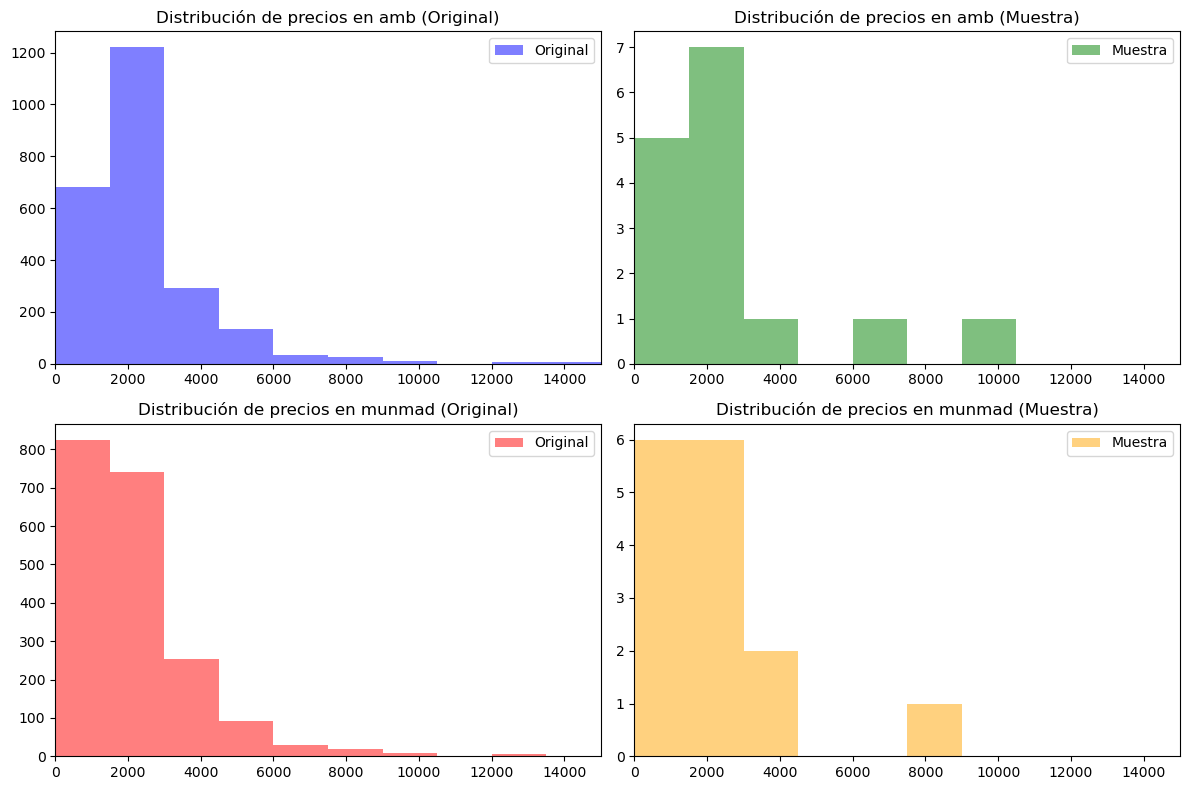

In [12]:
# Crear subgráficos para mostrar los histogramas
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Definir los límites y la separación del eje x
x_min = 0
x_max = 15000
bin_width = 1500
num_bins = int((x_max - x_min) / bin_width)

# Histograma de los datos originales de amb
axs[0, 0].hist(amb['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='blue', alpha=0.5, label='Original')
axs[0, 0].set_title('Distribución de precios en amb (Original)')
axs[0, 0].legend()

# Histograma de los datos de la muestra de amb
axs[0, 1].hist(muestra_amb['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='green', alpha=0.5, label='Muestra')
axs[0, 1].set_title('Distribución de precios en amb (Muestra)')
axs[0, 1].legend()

# Histograma de los datos originales de munmad
axs[1, 0].hist(munmad['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='red', alpha=0.5, label='Original')
axs[1, 0].set_title('Distribución de precios en munmad (Original)')
axs[1, 0].legend()

# Histograma de los datos de la muestra de munmad
axs[1, 1].hist(muestra_munmad['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='orange', alpha=0.5, label='Muestra')
axs[1, 1].set_title('Distribución de precios en munmad (Muestra)')
axs[1, 1].legend()

# Ajustar los límites del eje x
for ax in axs.flat:
    ax.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

In [13]:
print(muestra_amb.columns.tolist())
print(muestra_munmad.columns.tolist())

['ID', 'Title', 'Link', 'precio_euros', 'codigo_inmueble', 'Description', 'last_mod', 'dummy_indice', 'indice_alquiler', 'area', 'n_rooms', 'price_m2', 'n_baths', 'n_aseo', 'laundry', 'buhardilla', 'despacho', 'trastero', 'terrace', 'kwhm2_year', 'kgCO2m2_year', 'dummy_consum_EPC', 'dummy_emission_EPC', 'consum_A', 'consum_B', 'consum_C', 'consum_D', 'consum_E', 'consum_F', 'consum_G', 'emission_A', 'emission_B', 'emission_C', 'emission_D', 'emission_E', 'emission_F', 'emission_G', 'AC', 'parking', 'pool', 'lift', 'furniture', 'public_transp', 'barrio', 'codigo_inmueble_numero', 'Lat_Y', 'Lon_X', 'multifam', 'atico', 'duplex', 'estudio', 'loft', 'piso', 'triplex', 'qprecio']
['ID', 'Title', 'Link', 'precio_euros', 'codigo_inmueble', 'Description', 'last_mod', 'dummy_indice', 'indice_alquiler', 'area', 'n_rooms', 'price_m2', 'n_baths', 'n_aseo', 'laundry', 'buhardilla', 'despacho', 'trastero', 'terrace', 'kwhm2_year', 'kgCO2m2_year', 'dummy_consum_EPC', 'dummy_emission_EPC', 'consum_A',

In [14]:
muestra_amb2=muestra_amb.drop(columns=['qprecio'])
muestra_amb2['AMB']=1
muestra_amb2['MAD']=0

muestra_munmad2=muestra_munmad.drop(columns=['qprecio'])
muestra_munmad2['AMB']=0
muestra_munmad2['MAD']=1

In [15]:
eva_alquiler = pd.concat([muestra_amb2, muestra_munmad2], ignore_index=True)

# Venta

In [16]:
amb=pd.read_excel('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/primera_ronda/v-amb-abril24.xlsx')
mad=pd.read_excel('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/primera_ronda/v-prov_mad-abril24.xlsx')

# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(mad['Lon_X'], mad['Lat_Y'])]
crs = 'epsg:4326'  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(mad, crs=crs, geometry=geometry)
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

geomad=gpd.read_file('G:/Mi unidad/Datos/españa/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')
geomad=geomad[geomad['NAMEUNIT']=='Madrid']

munmad = gpd.sjoin(gdf_puntos, geomad[['geometry']], how='inner', predicate='intersects')
munmad=munmad.drop(['geometry','index_right'],axis=1)

In [17]:
# Creas una nueva columna en cada DataFrame con los quintiles
amb['qprecio'] = pd.qcut(amb['precio_euros'], 5, labels=False)
munmad['qprecio'] = pd.qcut(munmad['precio_euros'], 5, labels=False)

In [18]:
# Calcula el tamaño de muestra deseado para cada quintil
tamano_muestra_por_quintil = int(len(amb) * 0.0011)  

# Define una función para muestrear estratificadamente cada DataFrame
def muestreo_estratificado(df):
    # Realiza el muestreo estratificado por quintil
    muestra_estratificada = df.groupby('qprecio').apply(lambda x: x.sample(tamano_muestra_por_quintil, random_state=42))
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a cada DataFrame
muestra_amb = muestreo_estratificado(amb)
len(muestra_amb)

55

In [19]:
# Calcula el tamaño de muestra deseado para cada quintil
tamano_muestra_por_quintil = int(len(munmad) * 0.0025)

# Define una función para muestrear estratificadamente cada DataFrame
def muestreo_estratificado(df):
    # Realiza el muestreo estratificado por quintil
    muestra_estratificada = df.groupby('qprecio').apply(lambda x: x.sample(tamano_muestra_por_quintil, random_state=42))
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a cada DataFrame
muestra_munmad = muestreo_estratificado(munmad)
len(muestra_munmad)

55

In [20]:
muestra_amb2=muestra_amb.drop(columns=['qprecio'])
muestra_amb2['AMB']=1
muestra_amb2['MAD']=0

muestra_munmad2=muestra_munmad.drop(columns=['qprecio'])
muestra_munmad2['AMB']=0
muestra_munmad2['MAD']=1

In [21]:
eva_venta = pd.concat([muestra_amb2, muestra_munmad2], ignore_index=True)

# Unión de alquiler y venta

In [22]:
eva_inicio=pd.concat([eva_alquiler, eva_venta])
eva_inicio.head()

,ID,Title,Link,precio_euros,codigo_inmueble,Description,last_mod,dummy_indice,indice_alquiler,area,...,Lon_X,multifam,atico,duplex,estudio,loft,piso,triplex,AMB,MAD
0,1855,Alquiler Piso en Carrer del consell de cent 451,https://www.habitaclia.com/alquiler-piso-calle...,1250,Anuncio: 49444000000010,OPORTUNIDAD EN EIXAMPLE DRETA!PISO ESPECIALMEN...,27/02/2024,0,0.0,85,...,2.174846,1,0,0,0,0,1,0,1,0
1,2520,Alquiler Piso en Avinguda de cerdanyola 47. ...,https://www.habitaclia.com/alquiler-piso-moder...,1250,Anuncio: 1903004403789,Bonito y moderno piso de alquiler de dos habit...,06/03/2024,0,0.0,68,...,2.090375,1,0,0,0,0,1,0,1,0
2,2370,Alquiler Piso Avinguda de martí pujol. Piso e...,https://www.habitaclia.com/alquiler-piso-en_en...,1350,Anuncio: 11639004448685,"Piso de 100m², compuesto de 4 dormitorios (2 d...",14/03/2024,0,0.0,105,...,2.245174,1,0,0,0,0,1,0,1,0
3,259,Alquiler Piso en C/ bach de roda. Solvia inm...,https://www.habitaclia.com/alquiler-piso-solvi...,1550,Anuncio: 44419000002484,PROMOCIÓN: ¡ALTA DE SUMINISTROS GRATIS si rese...,14/03/2024,0,0.0,77,...,2.205807,1,0,0,0,0,1,0,1,0
4,311,Alquiler Piso Carrer de montmany,https://www.habitaclia.com/alquiler-piso-vila_...,1400,Anuncio: 27784003851232,MAGNÍFICA VIVIENDA A ESTRENAR-RECIÉN REFORMADA...,12/03/2024,0,0.0,85,...,2.160815,1,0,0,0,0,1,0,1,0


In [23]:
eva_inicio.reset_index(drop=True, inplace=True)
eva_inicio.index = eva_inicio.index + 1
eva_inicio.insert(0, 'ID_general', eva_inicio.index)

In [24]:
eva_inicio['C_contempo']=None
eva_inicio['C_estado']=None
eva_inicio['C_armarios']=None

eva_inicio['B_contempo']=None
eva_inicio['B_estado']=None
eva_inicio['B_lavamano']=None

eva_inicio['R_contempo']=None
eva_inicio['R_estado']=None
eva_inicio['R_carpinteria']=None
eva_inicio['R_singular']=None
eva_inicio['R_ventana']=None

eva_inicio['dumi_precio_reduccion']=None
eva_inicio['Precio_reduccion']=None
eva_inicio['Anuncio_invalido']=None

In [25]:
len(eva_inicio)

140

In [26]:
eva_inicio.to_excel('tercer_intento/evaluacion_inicio.xlsx', index=False)